### we will understanding the difference between the GPT-2 and Qwen3


<img src="/DATA/pyare/Routine/LLM/Reasoning/reasoning-from-scratch-pyare/ch02/appendix-c-Qwen3-implementation/C__image001.png" alt="1" width="700">

- Qwen3 (2025) and GPT-2 (2019) both are verysimilar overall in that they are both based on decoder submodule of the original transformer architecture.
- However, some of the design choices have evolved since 2019.
- In this Appendix we will only discuss breifly about the implementations. Then we can follow the chapter 5 LLM from scratch.

# C.1 Root Mean Square layer normalization (RMSNorm)

- GPT-2 uses the standard `LayerNorm`, the newer Qwen3 architecture replace it with `root mean square layer normalization (RMSNorm)`.
- This is the trend that has become increasigly common in recent model architectures.
- RMSNorm fulfills the same core function as LayerNorm: Normalizing layer activations to stablize and improve training.
- However, it simplifies the computation by removing the mean-centering step. This means that activations will still be normalized, but they are not centered at 0.<br>

<img src="/DATA/pyare/Routine/LLM/Reasoning/reasoning-from-scratch-pyare/ch02/appendix-c-Qwen3-implementation/C__image002.png" alt="1" width="700">


- `LayerNorm` subtracts the mean and devides by the standard deviation such that the layer outputs have a zero mean and unit variance (variance of one and standard deviation of one) which results in favorable properties, in terms of gradient values, for stable training.
- `RMSNorm` devides the inputs by the root mean square. This scale activation to a comparable magnitude without enforcing zero mean or unit variance.
- Both `LayerNorm` and `RMSNorm` stablize activation scales and improve optimization, however RMSNorm is often preffered in large scale LLMs because it is computationally cheaper.
- Unlike `LayerNorm`, `RMSNorm` does not use a bias (shift) term by default, which reduces the number of trainable parameters. Moreover, `RMSNorm` reduces the expensive mean and variance computations to a `single root-mean-square operation`. This reduces the number of cross-feature reductions from `two to one`, which lowers communication overhead on GPUs and slightly improves training efficiency.


- Look at section 4.2 LayerNorm for more details (LLM from scratch)

## 4.2 Normalizing activations with layer Normalization

In [1]:
import torch
import torch.nn  as nn
torch.manual_seed(123)

# create 2 training examples with 5 dimentions (features) each
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(f"Initial Batch : {batch_example}\n")
print(f"After Activation (out) : {out}")

Initial Batch : tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

After Activation (out) : tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


----

## `Keepdim = True/False`
- Let's compute the mean and variance for each of the 2 inputs above:

In [2]:
sum(out[0]/6)

tensor(0.1324, grad_fn=<AddBackward0>)

In [3]:
mean = out.mean(dim = -1, keepdim = True)
var = out.var(dim = -1, keepdim = True)
print("Mean:\n", mean)
print("Variance :\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance :
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


-`Keepdim = True` ensure that the output tensor retains the same number of dimensions as the input tensor, even though the operation reduces the tensor along the dimension specified via dim.

- For instance, without `keepdim= True`, the return tensor would be a two-dimensional vector [0.1324,0.2170] instead of [[0.1324],[0.2170]]

In [4]:
mean_without_keepdim = out.mean(dim = -1, keepdim = False)
var_without_keepdim = out.var(dim = -1, keepdim = False)
print("Mean:\n", mean_without_keepdim)
print("Variance :\n", var_without_keepdim)

Mean:
 tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)
Variance :
 tensor([0.0231, 0.0398], grad_fn=<VarBackward0>)


In [5]:
print("Mean shape:\n", mean_without_keepdim.shape)
print("Variance shape:\n", var_without_keepdim.shape)

Mean shape:
 torch.Size([2])
Variance shape:
 torch.Size([2])


In [6]:
print("Mean shape:\n", mean.shape)
print("Variance shape:\n", var.shape)

Mean shape:
 torch.Size([2, 1])
Variance shape:
 torch.Size([2, 1])


## `dim = 0/1/-1`
- About the `dim` parameter: specifies the dimensions along which the calculation of the statistic (here mena or variance) should be performed.

<img src = "/DATA/pyare/Routine/LLM/Reasoning/reasoning-from-scratch-pyare/ch02/appendix-c-Qwen3-implementation/Screenshot from 2025-11-23 18-08-43.png">

In [7]:
mean_without_dim = out.mean(dim = 0, keepdim = False)
var_without_dim = out.var(dim = 0, keepdim = False)
print("Mean:\n", mean_without_dim)
print("Variance :\n", var_without_dim)

Mean:
 tensor([0.2196, 0.2932, 0.0000, 0.3707, 0.1649, 0.0000],
       grad_fn=<MeanBackward1>)
Variance :
 tensor([8.0247e-05, 5.7816e-03, 0.0000e+00, 4.4471e-02, 5.4367e-02, 0.0000e+00],
       grad_fn=<VarBackward0>)


In [8]:
mean_without_dim = out.mean(dim = 1, keepdim = True)
var_without_dim = out.var(dim = 1, keepdim = True)
print("Mean:\n", mean_without_dim)
print("Variance :\n", var_without_dim)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance :
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


----

In [9]:
import torch
import torch.nn 
torch.manual_seed(123)

# create 2 training examples with 5 dimentions (features) each
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(f"Initial Batch : {batch_example}\n")
print(f"After Activation (out) : {out}")

mean = out.mean(dim = -1, keepdim = True)
var = out.var(dim = -1, keepdim = True)
print("Mean:\n", mean)
print("Variance :\n", var)

Initial Batch : tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

After Activation (out) : tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance :
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [10]:
# Out_norm 
out_norm = (out - mean)/torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)
mean = out_norm.mean(dim = -1, keepdim = True)
print("Mean:\n",mean)
var = out_norm.var(dim = -1, keepdim = True)
print("Variance:\n",var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
torch.set_printoptions(sci_mode = False)
print("Mean:\n", mean)
print("Variance:\n",var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
# Listing 4.2 in the LLM from scratch : A layer normalization class

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-6
        self.scale = nn.Parameter(torch.ones(emb_dim)) # Learnable
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # Learnable

    def forward(self,x):
        mean = x.mean(dim = -1, keepdim =True)
        var = x.var(dim = -1, keepdim =True, unbiased = False)
        norm_x = (x-mean)/torch.sqrt(var + self.eps) # eps is added to avoid the division by zero

        return self.scale*norm_x+ self.shift


**Biased variance**\n
- In the variance calculation above, setting `unbiased=False` means using the formula 
$\\frac{\\sum_i (x_i - \\bar {x})^2}{n}$ 
to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance \n",
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1`\n", is negligible\n",
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters\n","\n",
- Let's now try out `LayerNorm` in practice:

In [13]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)

In [14]:
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True, unbiased = False)
print("Mean:\n", mean)
print("Variance:\n",var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


----

## RMSNorm

- RMSNorm does not use a bias (shift) term by default, which reduce the number of trainanle parameters.

In [15]:
print(var)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [16]:
var_rms = out.pow(2).mean(dim= -1, keepdim  = True)
print(var_rms)
norm_out_rms = out* torch.rsqrt(var_rms)
print(norm_out_rms)

tensor([[0.0368],
        [0.0803]], grad_fn=<MeanBackward1>)
tensor([[1.1786, 1.8097, 0.0000, 1.1559, 0.0000, 0.0000],
        [0.7527, 0.8449, 0.0000, 1.8345, 1.1637, 0.0000]],
       grad_fn=<MulBackward0>)


In [17]:
# Listing C.1 RMSNorm
import torch.nn as nn
import torch


class RMSNorm(nn.Module):

    def __init__(
        self,
        emb_dim,
        eps = 1e-6,
        bias = False,
        qwen3_compatible = True):

        super().__init__()
        self.eps = eps
        self.qwen3_compatible = qwen3_compatible
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self,x):
        input_dtype = x.dtype

        if self.qwen3_compatible:
            x = x.to(torch.float32)

        variance = x.pow(2).mean(dim=-1, keepdim = True)
        norm_x = x*torch.rsqrt(variance + self.eps)
        norm_x = norm_x * self.scale

        if self.shift is not None:
            norm_x = norm_x + self.shift

        return norm_x.to(input_dtype)

In [18]:
rms_ln = RMSNorm(emb_dim = 5)
rms_out_ln = rms_ln(batch_example)
rms_mean = rms_out_ln.mean(dim = -1, keepdim = True)
rms_var = rms_out_ln.var(dim = -1, keepdim = True, unbiased = False)
print("Mean:\n", rms_mean)
print("Variance:\n",rms_var)

Mean:
 tensor([[-0.6253],
        [-0.4500]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.6090],
        [0.7975]], grad_fn=<VarBackward0>)


# C.2 Feed Forward module

---
- We will look into the Feed Forward network of GPT-2 first and then we will look into the Qwen3 Feed Forward network

<img src = "/DATA/pyare/Routine/LLM/Reasoning/reasoning-from-scratch-pyare/ch02/appendix-c-Qwen3-implementation/C__image003.png">

- In this they introduced the 3rd linear layer and multiplied the output of 3rd linear layer to the activated linear layer 1. 
-  At the first glance it seems that Qwen3 feedforward will have more parameters and should outperform the standard GPT-2 model, Simply because it adds an extra linear layer ( three instead of two). However intitution is misleading. fc1 and fc2 layers in the GLU variant 

## GPT-2 : Section 4.3 from LLM from scratch : Implementing a feed forward network with `GELU` activations.
- First we will implement the activation function.
    - ReLU (Rectified Linear Unit) : ReLU is simple and computationally cheap, but it has a sharp kink at zero. This motivated researchers to explore smoother functions such as the Gaussian error unit (GELU) and the sigmoid linear unit (SiLU)
    - GLU (Gated Linear Unit)
    - SwiGLU ( Swish-gated linear unit)
    - GELU (Gaussian error Linear Unit)
    - SiLU : ( Sigmoid linear Unit) We will discuss this later

<img src ="/DATA/pyare/Routine/LLM/Reasoning/reasoning-from-scratch-pyare/ch02/appendix-c-Qwen3-implementation/C__image004.png">

- ToDO
    - Implement Simple Activation functions and then GELU

**GELU**:<br>
 Defined as GELU(x) = x.(x), where (x) is the cumulative distribution function (CDF) of the standard Gaussian distribution.Computing this CDF is slow because it uses piecewise logic and exponentials, which makes it hard to write fused, optimized GPU kernels (although a tanh approximation exists that uses cheaper operations and runs faster with near-identical results).In short, while GELU produces smooth activation curves, it is overall computationally more expensive than simpler functions.

 **SiLU**:<br>
 Newer models have largely replaced GELU with the SiLU (also known as Swish) function, which smoothly suppresses large negative inputs toward ~0 and is approximately linear for large positive inputs. SiLU has a similar smoothness, but it is slightly cheaper to compute than GELU and offers comparable modeling performance. In practice, SiLU is now used in most architectures, while GELU remains in use in only some models, such as Google's Gemma open-weight LLM. In the implementation of the feed forward module in listing C.2, this `SiLU` function is called via nn.functional.silu. The feed forward module in listing C.2 is also often called `SwiGLU`, an abbreviation that is derived from the terms `Swish` and `GLU`.

A good source to look at and we can build based on this : 
1. (converting-gpt-to-llama2.ipynb)[https://github.com/rasbt/LLMs-from-scratch/blob/c19533851ff7268ae4a80fa0da28d1bf9b3ab217/ch05/07_gpt_to_llama/converting-gpt-to-llama2.ipynb#L234]
2. (LLM from schratch Chapter 4)[https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb]


### This is Qwen3 FeedForward network


In [19]:
# Listing C.2 Qwen3 feed forward module
class FeedForwards(nn.Module):
    def __init__(self,cfg):
        super().__init__()

        self.fc1 = nn.Linear(
            cfg["emb_dim"],cfg["hidden_dim"], dtype = cfg["dtype"], bias = False
        )

        self.fc2 = nn.Linear(
            cfg["emb_dim"],cfg["hidden_dim"], dtype = cfg["dtype"], bias = False
        )

        self.fc3 = nn.Linear(
            cfg["hidden_dim"],cfg["emb_dim"], dtype = cfg["dtype"], bias = False
        )

    def forward(self,x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.silu(x_fc1)* x_fc2 # We will discuss about SiLU later
        return self.fc3(x)

#### Lets See the ChatGPT FeedForward network imlementations from LLM from scratch ( 4.3)

- GELU Actiation function ( Gaussian Error Linear Unit ) : GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, its common to implement the computational cheaper approximation: <br>

$$
\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$$

## GELU

In [21]:
# Listing 4.3 An Implementation of GELU (Gaussian Error Linear Unit) activation function

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x *(1+ torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x + 0.044715* torch.pow(x,3))
        ))

## SiLU : Sigmoid Weighted Linear Unit

- Llama  and Qwen3 uses the SiLU activation function ( insted of GELU), which is also known as Swish function:
$$
\text{silu}(x) = x \cdot \sigma(x), \quad \text{where} \quad \sigma(x) \quad \text{is the logistic sigmoid.}
$$

- For more information read [SiLU paper, (2017)](https://arxiv.org/pdf/1702.03118)

In [22]:

class SiLU(nn.Module):

    def __init__(self):
        super(SiLU, self).__init__()

    def forward(self,x):

        return x*torch.sigmoid()

## GLU : Gated Linear Unit 

- A variant of SiLU called SwiGLU, which essentially results in a slightly different structured `FeedForward` module

- SwiGLU uses a gating mechanism in the feedforward layer, with the formula : [more details](https://arxiv.org/abs/2002.05202)
$$
\text{SwiGLU}(x) = \text{SiLU}(\text{Linear}_1(x)) * (\text{Linear}_2(x))

$$

```python
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)
        self.silu = SiLU()

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2
        return self.fc3(x)
```

- Note that we also added a `dtype=cfg["dtype"]` setting above, which will allow us to load the model directly in lower precision formats later to reduce memory usage (versus instantiating it in the original 32-bit precision format and then converting it)
- We also set `bias=False` since Llama doesn't use any bias units

In [23]:
#!uv pip install matplotlib

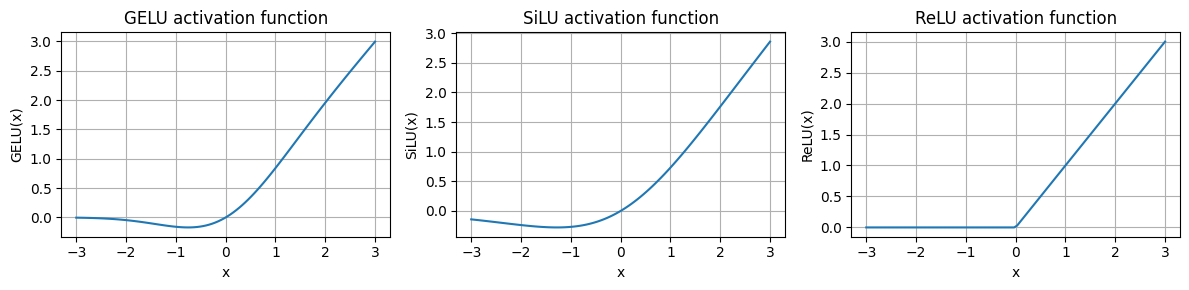

In [24]:
import matplotlib.pyplot as plt
gelu, relu, silu = GELU(), nn.ReLU(), nn.SiLU()

x = torch.linspace(-3,3,100) # Create the 100 data samples from -3 to 3 
#print(x)
y_gelu, y_relu, y_silu = gelu(x), relu(x), silu(x)
#print(y_silu)
plt.figure(figsize=(12,3))

for i, (y,label) in enumerate(zip([y_gelu, y_silu, y_relu ],["GELU", "SiLU","ReLU"]),1): # i= 1,2,3 index from enumerate, zip give you pair of ( activation output, "GELU" i.e. name we gave)
    plt.subplot(1,3,i) # Row, Columns and index

    plt.plot(x,y)

    plt.title(f"{label} activation function")

    plt.xlabel("x")

    plt.ylabel(f"{label}(x)")

    plt.grid(True)

plt.tight_layout()

plt.show()


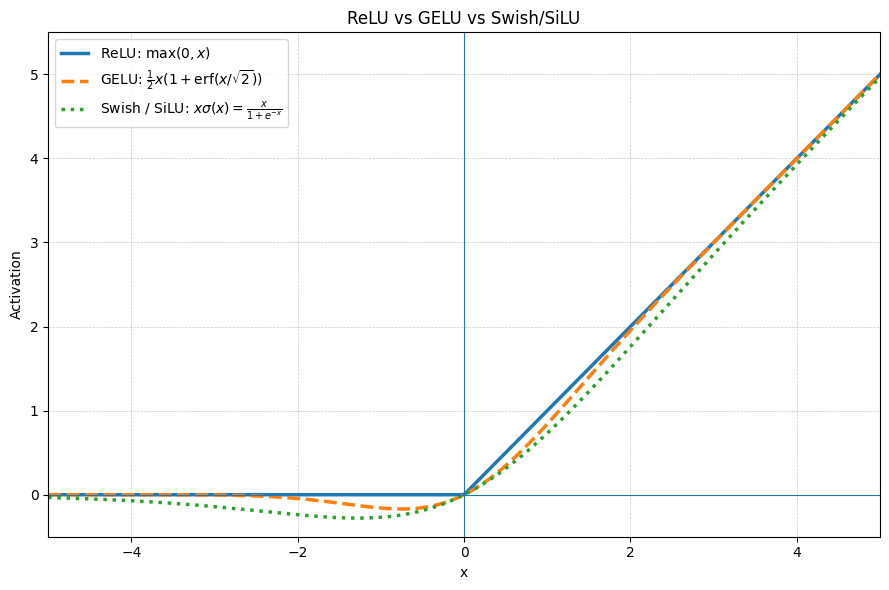

In [25]:
# Overlayed for better visualization
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

gelu, relu, silu = GELU(), nn.ReLU(), nn.SiLU()

x = torch.linspace(-5, 5, 400)
y_gelu, y_relu, y_silu = gelu(x), relu(x), silu(x)

plt.figure(figsize=(9, 6))

plt.plot(x, y_relu, linewidth=2.5,
         label=r"ReLU: $\max(0, x)$")
plt.plot(x, y_gelu, linewidth=2.5, linestyle="--",
         label=r"GELU: $\frac{1}{2} x (1 + \mathrm{erf}(x / \sqrt{2}))$")
plt.plot(x, y_silu, linewidth=2.5, linestyle=":",
         label=r"Swish / SiLU: $x \sigma(x) = \frac{x}{1 + e^{-x}}$")

plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)

plt.xlabel("x")
plt.ylabel("Activation")
plt.title("ReLU vs GELU vs Swish/SiLU")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(loc="upper left")
plt.xlim(-5, 5)
plt.ylim(-0.5, 5.5)

plt.tight_layout()
plt.show()


In [26]:
# Listing 4.4 A Feed forward neural network module 
class FeedForwards_GPT2(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )


    def forward(self,x):

        return self.layers(x)

<img src = "/DATA/pyare/Routine/LLM/Reasoning/reasoning-from-scratch-pyare/ch02/appendix-c-Qwen3-implementation/Screenshot from 2025-12-05 10-03-52.png">

In [27]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11008,     # NEW: Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # NEW: Lower-precision dtype to reduce memory usage
}


QWEN_CONFIG_06_B = {
    "vocab_size": 151_936,     # Vocabulary size
    "context_length": 40_960,  # Length originally used during training
    "emb_dim": 1024,           # Embedding dimension
    "n_heads": 16,             # Number of attention heads
    "n_layers": 28,            # Number of layers
    "hidden_dim": 3072,        # Size of intermediate dim in FeedForward
    "head_dim": 128,           # Size of the heads in GQA
    "qk_norm": True,           # Whether to normalize queries & keys in GQA
    "n_kv_groups": 8,          # Key-Value groups for GQA
    "rope_base": 1_000_000.0,  # The base in RoPE's "theta"
    "dtype": torch.bfloat16,   # Lower-precision dtype to reduce memory
}

In [28]:
# Listing C.2 Qwen3 feed forward module
class FeedForwards(nn.Module):
    def __init__(self,cfg):
        super().__init__()

        self.fc1 = nn.Linear(
            cfg["emb_dim"],cfg["hidden_dim"], dtype = cfg["dtype"], bias = False
        )

        self.fc2 = nn.Linear(
            cfg["emb_dim"],cfg["hidden_dim"], dtype = cfg["dtype"], bias = False
        )

        self.fc3 = nn.Linear(
            cfg["hidden_dim"],cfg["emb_dim"], dtype = cfg["dtype"], bias = False
        )

    def forward(self,x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.silu(x_fc1)* x_fc2 # We will discuss about SiLU later
        return self.fc3(x)

In [29]:
#ffn_gpt2 = FeedForwards_GPT2(QWEN3_CONFIG)
ffn_qwen3 = FeedForwards(QWEN_CONFIG_06_B)
x = torch.rand(2,3,1024, dtype=torch.bfloat16)
#out_gpt2 = ffn_gpt2(x)
out_qwen3 = ffn_qwen3(x)
#print(out_gpt2.shape)
print(out_qwen3.shape)

torch.Size([2, 3, 1024])


----

### What is gated feed-forward network? 
- These also called as gated linear units, GLU, SwiGLU, GEGLU
#### 1. Standard FFN (baseline)
```scss
x → Linear(emb → hidden)
   → activation (ReLU, GELU, etc.)
   → Linear(hidden → emb)
```

Like GPT-2 
```python
# Listing 4.4 A Feed forward neural network module 
class FeedForwards_GPT2(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]), # here 4* emb_dim is the hidden_dim
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )


    def forward(self,x):

        return self.layers(x)
    
```
Mathematically:
```ini
h = activation(W1 * x)
y = W2 * h
```



#### 2. Gated FFN (high-level idea)
Gated FFNs introduce two parallel projections instead of one:

```java
x → W1 → gate
x → W2 → value
output = activation(gate) ⊙ value
```
(⊙ = elementwise multiply)

Often followed by a third projection:

```java
x → W1 → gate
x → W2 → value
h = activation(gate) * value
y = W3 * h
```
So instead of:
```ini
h = f(W1 x)
```
You get:
```ini
h = f(W1 x) * (W2 x)
```
This is exactly the pattern you implemented:
```python
x_fc1 = self.fc1(x)               # gate
x_fc2 = self.fc2(x)               # value
x = silu(x_fc1) * x_fc2           # gated activation
return self.fc3(x)
```
#### 3. Why do this? (Intuition)

Think of the gate as giving the network a learnable, input-dependent filter that controls what parts of the hidden representation get passed forward.

**Analogy:**
- `activation(W1 x)` → how much each feature should turn on
- `(W2 x)` → the value of each feature
Multiplying them means:
Features can be scaled up, down, or suppressed depending on context.
It’s like attention, but inside the feed-forward layer.

4. [Why is this useful for language modeling?](https://arxiv.org/abs/2002.05202) 
Allows conditional computation

The network can dynamically amplify or suppress features based on the token context.
Adds multiplicative interactions

Normal FFNs are additive:
```nginx
linear + activation
```
Gated FFNs are multiplicative:
```scss
activation(gate) * value
```
This is a more expressive mathematical operation.
Helps with feature sparsity
Many neurons become silent unless activated by the gate:
```scss
activation(gate) ≈ 0  → turn feature off
```
This creates sparse activation patterns, which help scaling.
Improves training stability

Especially with smooth activations like SiLU (used in SwiGLU):

```python
silu(x) = x * sigmoid(x)
```
SiLU is differentiable everywhere and avoids abrupt changes.

Elementwise multiply allows interaction between features:
```scss
(feature importance) * (feature value)
```


---

## C.3 Rotary Possition Embedding (RoPE)

- In transformers based LLMs positional encoding is neccassary because of the attention mechanism.
- By Default, attention treats the input tokens as they have no order.
- In original, GPT architecture, absolute possitional embeddings addressed this by adding a learned embedding vector for each position in the sentence, which is then added to the token embeddings.

In [31]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",
    "torch",
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 1.1.4
torch version: 2.9.1


In the GPT model, the positional embeddings are implemented as follows:
```python 
self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
```

-  [RoPE ( Rotary Possition Embeddings):](https://arxiv.org/abs/2104.09864)

this introduces a different approach, instead of adding position information as seprate embeddings, it encodes position information by rotating the query and key vector in the attention mechanism (Section C.4) in a way that depends on each token's possition.
- RoPE is an elegant idea but also a long topic itself. It was first introduced in 2021, RoPE became widely adopted with the release of the original Llamma model in 2023 and has become a staple in modern LLMs, so it is not unique to Qwen3.

### RoPE can be implemented in two mathematically equivalent ways.
1. Interleaved form: Which pairs adjacent dimentions for rotation, or in a two halves form.
2. Two halves form similar to [modeling_llama.py ](https://github.com/huggingface/transformers/blob/e42587f596181396e1c4b63660abf0c736b10dae/src/transformers/models/llama/modeling_llama.py#L173-L188), We will implement this variant as this is easy to read and understand.
3. The original RoPE paper and Meta's official Llama 2 repository, however, use the interleaved (even/odd) version [(llama/model.py)](https://github.com/meta-llama/llama/blob/6c7fe276574e78057f917549435a2554000a876d/llama/model.py#L64-L74); but as mentioned earlier, they are equivalent



In [49]:
# Listing C.3 RoPE
from os import posix_spawn
from numpy import dtype
import torch


def compute_rope_params(head_dim, theta_base = 10_000, context_length = 4096, dtype = torch.float32):

    assert head_dim % 2 ==0, "Embedding Dimensions must be even"

    inv_freq = 1.0 / (
        theta_base ** (torch.arange(0, head_dim, 2, dtype= dtype)[: (head_dim//2)]/ head_dim)
        )


    positions = torch.arange(context_length, dtype=dtype)
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)

    angles = torch.cat([angles,angles], dim = 1)

    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin, offset = 0):

    batch_size, num_heads, seq_len, head_dim = x.shape

    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2] # First Half 
    x2 = x[..., head_dim // 2:] # Second half

    cos = cos[offset: offset + seq_len, :].unsqueeze(0).unsqueeze(0)

    sin = sin[offset:offset + seq_len,:].unsqueeze(0).unsqueeze(0)


    # shape after : (1,1, seq_len, head_dim)

    rotated = torch.cat((-x2,x1), dim = -1)


    x_rotated = (x* cos) + (rotated * sin)

    return x_rotated.to(dtype = x.dtype)


The implementation in the book has choosen the split halves style

1) Split-halves style (this book, Hugging Face Transformers):
```text
[ x0   x1   x2   x3   x4   x5   x6   x7 ]
  │    │    │    │    │    │    │    │
  ▼    ▼    ▼    ▼    ▼    ▼    ▼    ▼
 cos  cos  cos  cos  sin  sin  sin  sin
```

Rotation Matrix
```text
      [ cosθ   -sinθ    0      0   ... ]
      [ sinθ    cosθ    0      0   ... ]
      [  0       0    cosθ   -sinθ ... ]
      [  0       0    sinθ    cosθ ... ]
```


The Embedding dimensions are split into two halves and then each one is rotated in blocks.

2) Interleaved (even/odd) style (original paper Llama repo)

```text
      [ x0   x1   x2   x3   x4   x5   x6   x7 ]
        │    │    │    │    │    │    │    │
        ▼    ▼    ▼    ▼    ▼    ▼    ▼    ▼
       cos  sin  cos  sin  cos  sin  cos  sin
```

Rotation matrix:

```text
      [ cosθ  -sinθ    0      0   ... ]
      [ sinθ   cosθ    0      0   ... ]
      [  0      0    cosθ   -sinθ ... ]
      [  0      0    sinθ    cosθ ... ]
```

- Here, embedding dims are interleaved as even/odd cosine/sine pairs.
- Both layouts encode the same relative positions. The only difference is how dimensions are paired

Following is an example of applying RoPE to the `q` and `k` tensors.

In [42]:
torch.arange(0, 16, 2, dtype = torch.float32)[: (16//2)].float()/16

tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750])

In [47]:
# Settings 
batch_size = 2 
context_len = 5
num_heads = 4 
head_dim = 16

# Instantiate the RoPE parameters

cos, sin = compute_rope_params(head_dim = head_dim, context_length = context_len)

# Dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, context_len, head_dim)
keys = torch.randn(batch_size, num_heads, context_len, head_dim)


# Apply rotary position embeddings

queries_rot = apply_rope(queries, cos, sin)
keys_rot = apply_rope(keys, cos,sin)

In [48]:
keys_rot

tensor([[[[-1.1065,  1.2682,  0.3147, -0.9990, -0.5298, -1.1257, -1.5839,
            0.1298,  1.8622, -0.7446,  0.3587,  0.8623,  0.9155,  1.0884,
            0.7310, -0.5469],
          [-0.7097, -0.7169,  0.9093, -0.1471,  0.7012,  0.3109, -1.1441,
           -0.5361, -1.6863,  0.5098, -0.8983,  0.2279, -0.5039, -1.0540,
            0.0784,  1.2255],
          [-1.1700, -0.8549, -0.7152,  1.4844, -0.3492,  0.6842, -0.1262,
           -1.2935,  1.3891,  0.8232,  0.0782, -0.8618,  1.1936,  2.7084,
            0.0260,  0.5215],
          [-0.2510, -0.9456, -1.5930,  0.7424, -0.2288,  0.3374, -1.3651,
           -1.1216,  0.3947, -0.7413, -0.6022, -0.3456, -0.4060,  0.4498,
           -0.9011,  0.0998],
          [ 0.2752,  0.5016, -0.8367,  0.0741, -0.2075, -1.5764,  0.0414,
           -1.3112, -0.5474, -2.2530, -1.3810, -0.8228,  0.2607,  0.0455,
            0.3777, -0.3443]],

         [[ 0.5645,  1.0475,  2.1908, -0.6795, -0.2195,  1.0675, -0.1212,
            0.2905,  1.0915,  2.09

In [ ]:
### 1.5 Add RoPE to MultiHeadAttention module (Come back to this once revise the chapter 3, 4 and 5 completely and all attentions also)
### Next first refer to revise notes of chapter-2-tokenization



# C.4 Grouped Query Attention (GQA)